## Bootstrap leptokurtotic equity returns :: SPX

Bootstrapping has two benefits: small-sample statistics
and simulation from controlled population.

Our source code is sufficiently general to be applied to other
financial assets besides the equities market index SPX:

- Efficient storage and rescaling of empirical data.
    - Normalize, but retain features of the empirical distribution.
- Design bootstrap to study alternate histories.
    - Visualize sample price paths.
    - Bootstrap for small-sample statistics.
    - Bootstrap for estimating probabilities of events.

Bootstrapping facilitates the study of small-sample behaviour for which
asymptotic statistical theory is unsuitable, or where closed-form
mathematical analysis is intractable.

In particular, we demonstrate:

- "geovolatility" is greater than volatility (approximately 10% to 20% more),
  thus there is more uncertainty surrounding the geometric mean rate,
  relative to the arithmetic mean rate, especially during downturns.

-  how one can estimate the probability that an asset will reach
   below a certain price level during some fixed time duration.

The idea in **Appendix 1** is to mix in synthetic data
derived from a theoretical model of the market.
We can express anticipated market conditions by
altering the parametization of the population array,
and also by overlaying the structure of a theoretical
model to produce hybrid results.

- Specify *hybrid population array* using synthetic rates of return
  from GM(2) Gaussian Mixture model.

### What is bootstrapping?

> In statistics, *bootstrapping* is any test or metric that relies
on random sampling with replacement. Bootstrapping allows assigning
measures of accuracy (defined in terms of bias, variance, confidence
intervals, prediction error) to sample estimates.
This technique allows estimation of the sampling distribution
of almost any statistic using resampling methods.

> Bootstrapping is the practice of estimating properties of an estimator
(such as its variance) by measuring those properties sampling from
an approximating distribution. One standard choice for an approximating
distribution is the empirical distribution function of the observed data.
In the case where a set of observations can be assumed to be from an
independent and identically distributed population, this can be
implemented by constructing a number of resamples with replacement.

> It may also be used for constructing hypothesis tests.
It is often used as an alternative to statistical inference
based on the assumption of a parametric model when that
assumption is in doubt, or where parametric inference is
impossible or requires complicated formulas for the
calculation of standard errors.

> ***The KEY IDEA of bootstrapping is that inference about a population
from sample data (sample → population) can be modelled by resampling
the sample data and performing inference about a sample from
resampled data (resampled → sample). As the population is unknown,
the true error in a sample statistic against its population value is unknown.
In bootstrap-resamples, the 'population' is in fact the sample, and this
is known; hence the quality of inference of the 
"true" sample from resampled data (resampled → sample) is measurable.***
(Credit goes to Bradley Efron at Stanford University.)

Reference: our edit of
https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

### How can bootstrapping be applied in finance?

In theory, asset prices are generally modeled by Lévy stochastic processes.
Some parametizations lead to infinite-variance models which empirically
exhibit so-called "fat tails." Athreya (1987) states,
"Unless one is reasonably sure that the underlying distribution
is not heavy tailed, one should hesitate to use the naive bootstrap."
Our data analysis shows that Gaussian mixture models which have
finite variance are sufficient to model leptokurtotic assets.

*If* the data is temporally correlated, bootstrapping will destroy the
inherent correlations. Our broad practical justification
in favor of bootstrapping here is that for short-term financial
time-series, most frequently, the best in-sample fit of an
ARIMA model to log(price) is AR(1) with unit root.
This implies that the underlying stochastic process is *memoryless*.
To add further credence, studies of post-sample performances
regularly show that it is extremely difficult to surpass the
most current price as the best forecast of prices over long
future horizons among all competing models.

The bootstrap procedure is ideal when the theoretical distribution
of a statistic of interest is analytically complicated.
Here we cover the *geometric* (not the traditional,
arithmetic) mean rates of return for very small sample sizes.
Our computation of geometric mean rates includes the effect
of varying non-Gaussian kurtosis (fourth central moment),
hence bootstrapping will give us numerical estimates
where the mathematics is analytically intractable.


References:

- fecon235, 2017 Jupyter notebook, Gaussian Mixture and Leptokurtotic Assets,
  https://git.io/gmix

- Athreya, K.B., 1987, Bootstrap of the mean in the infinite variance case,
  [Ann. Stats. 15:2:724-731](https://projecteuclid.org/download/pdf_1/euclid.aos/1176350371).
  
- URL shortcut for this notebook: https://git.io/bootspx  

*Dependencies:*

- fecon236 >= 10.7.1, source code, https://github.com/MathSci/fecon236
- fecon235 data file in `nb` directory, `boots_ndl_d4spx_1957-2018.csv.gz`
     
*CHANGE LOG*

    2018-07-31  First draft version.

In [1]:
import fecon236 as fe
#  esp. the sim and bootstap modules.

In [2]:
#  PREAMBLE-p10.18.0714 :: Settings, https://git.io/236pa
from __future__ import absolute_import, print_function, division
fe.system.specs()
%load_ext autoreload
%autoreload 2
#       Use 0 to disable autoreload when a module is modified.
#  NOTEBOOK DISPLAY OPTIONS...
fe.pd.set_option('display.notebook_repr_html', False)
#       Represent pandas DataFrames as text; not HTML representation.
from IPython.display import HTML  # Useful for snippets from web.
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile \
#            width=700 height=350></iframe>')
from IPython.display import Image
#  e.g. Image(filename='holt-winters-equations.png', embed=True)
#                  url= Also works instead of filename.
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True",
#  which will display results in secondary notebook pager frame in a cell.
%matplotlib inline
#  Generate PLOTS inside notebook, "inline" generates static png,
#  whereas "notebook" argument allows interactive zoom and resize.

 !:  Code for this project straddles python27 and python3.
 ::  Python 2.7.14
 ::  IPython 5.7.0
 ::  jupyter_core 4.4.0
 ::  notebook 5.4.0
 ::  matplotlib 1.5.1
 ::  numpy 1.11.3
 ::  scipy 1.0.0
 ::  statsmodels 0.8.0
 ::  sympy 1.1.1
 ::  pandas 0.22.0
 ::  pandas_datareader 0.6.0
 ::  fecon236 10.7.1
 ::  Repository: fecon235 v6.18.0623 develop
 ::  Timestamp: 2018-08-01T18:42:07Z


### Pre-computing the data file

We have created a CSV data file readable by Python which encodes
51 years of S&P 500 index data, SPX rates of return.

This routine may be applied to *any* time-series:

- Take differences of logged price, then normalize.
- Rates of return retain original features, but rescaled to N(0,1).
- Archive resulting file on disk to minimize download and computing time.
- Optionally, compress file (.gz works best) to save on disk space.

We show the **RECIPE** below for replication purposes. 


```
On 2018-06-30, we let fecon235/nb for notebooks
be our working directory...

>>> spx = fe.get(fe.d4spx)
 ::  S&P 500 prepend successfully goes back to 1957.

>>> fe.stat(spx)
                  Y
count  16043.000000
mean     611.773980
std      662.320517
min       38.980000
25%       95.755000
50%      267.050000
75%     1129.500000
max     2872.870000
kurtosis  3.393829

>>> fe.gm2gem(spx, yearly=256, b=3.5)
Geometric  mean rate: 5.0103
Arithmetic mean rate: 6.5026
sigma: 15.4936
kurtosis (Pearson): 31.5192
GM(2), sigma1: 6.0996
GM(2), sigma2: 54.2276
GM(2), q:  0.0699
GM(2), b:  3.5
yearly: 256
N: 16042

GM(2) refers to the parameters of a Gaussian mixture distribution.
In https://git.io/gmix we analytically and visually show how a
Gaussian Mixture model handles "fat tail" risk of leptokurtotic
financial assets under small-sample conditions.

Interestingly, b=2.5 and b=3.0 were inadequate for real solutions.
Kurtosis for a Gaussian distribution in theory is 3, but here
that statistic is extremely high at 31.52, so b=3.5 finally worked.

The initial price of the SPX series is 46.20 on 1957-01-02.
And the tailvalue is 2718.37 on 2018-06-29.
Sample size N for prices is 16043, while it is obviously one
less for data with one-period lag.

>>> fe.bs.writefile_normdiflog(spx, 'boots_ndl_d4spx_1957-2018.csv')
 ::  Dataframe written to file: boots_ndl_d4spx_1957-2018.csv

The size of the CSV file is 422805 bytes, but after gz compression
it shrank to 155776 bytes: boots_ndl_d4spx_1957-2018.csv.gz
which shall be git preserved in fecon235/nb.
```

### Decrypt the CSV data file

We read the file on disk to create a numpy array of pre-computed values
into computer memory. This array will be *repetitively* called
to be bootstrapped into prices which are constructed from
the cumulative product of financial returns.

In [3]:
# A look under the hood:
fe.bs.csv2ret??

Signature: fe.bs.csv2ret(datafile, mean=0.065026, sigma=0.154936, yearly=256)
Source:   
def csv2ret(datafile, mean=SPXmean, sigma=SPXsigma, yearly=256):
    '''Reform empirical N(0, 1) rates distribution as returns array.'''
    df = readcsv(datafile)    # Dataframe of normalized RATES of return.
    normarr = df['Y'].values  # That dataframe expressed as array.
    #                .values converts to numpy ARRAY form.
    #      The pandas index will no longer matter.
    #      Next, form an array to efficiently bootstrap later.
    poparr = sim.norat2ret(normarr, mean, sigma, yearly)
    #  TIP: For repetitive simulations, poparr should be PRE-COMPUTED.
    #     "POPULATION" array in RETURNS form (no longer rates):
    return poparr
File:      /media/yaya/virt18g/virt/dbx/Dropbox/ipy/fecon236/fecon236/boots/bootstrap.py
Type:      function


In [4]:
#  Let's document the numerical values of (mean, sigma) for the record:
(fe.bs.SPXmean, fe.bs.SPXsigma)

(0.065026, 0.154936)

In [5]:
#  At this point, the user could specify their mean and sigma,
#  but we shall use actual values computed from 51-year history:

poparr = fe.bs.csv2ret('boots_ndl_d4spx_1957-2018.csv.gz',
                       mean=fe.bs.SPXmean, sigma=fe.bs.SPXsigma,
                       yearly=256)

For our custom array, we use the fitted values corresponding
to the first two centralized moments, arithmetic `mean` and `sigma`^2.
But they can be set to any reasonable values.
We can regards them as the *gross* Gaussian descriptors,
since the *empirical data still contains non-Gaussian events.*

Given the initial price, `poparr` contains all the information
necessary to reconstitute the original price time-series,
if we process `poparr` sequentially with the original Gaussian descriptors.

Our key bootstrap idea is to resample from the rescaled `poparr` randomly
with our choice of the gross "population" descriptors.

In [6]:
#  Sanity check on array shape, expect: (16042,)
#  from which we can see the population size:
poparr.shape

(16042,)

In [8]:
#  Illustrate the KEY IDEA by our helper function:
fe.bs.bootstrap(3, poparr)

#  which outputs an array of three random values from poparr.
#  Rerun this cell, to see how resampling would work.

array([ 0.99566548,  1.00098084,  1.00317372])

### Simulation by boostrap from empirical data

It is very interesting to simulate from past observations,
rather than directly from a RNG random number generator,
and then to *visually see* the results.

For enthusiasts of "technical chart analysis"
our bootstrapped charts may exhibit familiar patterns
such as regions of support and resistance, trendlines, etc.
This sense of familiarity is good indication that
the simulation has been reasonable derived.

The important point here is that we know the
generating mechanism which reverse-engineers
the gross statistics of the "population" (see RECIPE above).
We can verify that the statistics estimated from ***subsamples***
*deviate much further than what we would expect*.
This happens because our bootstrapping technique
retains the non-Gaussian distributional features of the population
(despite normalization which is merely rescaling).

For example, the subsample statistics show signs
of leptokurtotic returns, where kurtosis varys
considerably, though the population kurtosis is
31.52 (one would theoretically expect 3 exactly if
the underlying stochastic process was Gaussian).

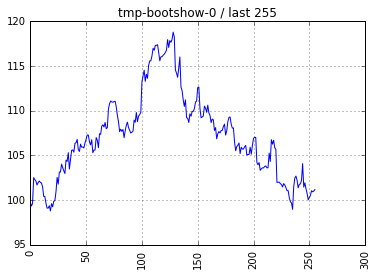

Geometric  mean rate: 0.4954
Arithmetic mean rate: 1.4273
sigma: 13.4077
kurtosis (Pearson): 6.4581
GM(2), sigma1: 12.7022
GM(2), sigma2: 46.9268
GM(2), q:  0.009
GM(2), b:  3.5
yearly: 256
N: 255
---------------------------------------0


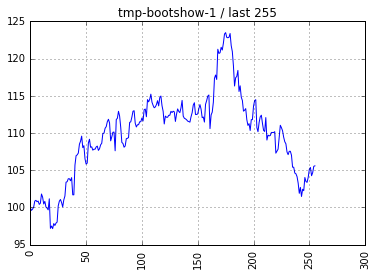

Geometric  mean rate: 4.0988
Arithmetic mean rate: 5.4955
sigma: 16.6041
kurtosis (Pearson): 6.1374
GM(2), sigma1: 15.8135
GM(2), sigma2: 58.1144
GM(2), q:  0.0082
GM(2), b:  3.5
yearly: 256
N: 255
---------------------------------------1


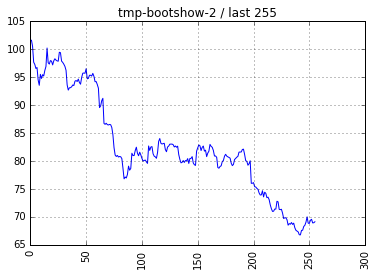

Geometric  mean rate: -41.6493
Arithmetic mean rate: -38.5637
sigma: 17.3047
kurtosis (Pearson): 7.5373
GM(2), sigma1: 16.0995
GM(2), sigma2: 60.5664
GM(2), q:  0.0118
GM(2), b:  3.5
yearly: 256
N: 255
---------------------------------------2


In [9]:
#  ENCOURAGE RE-RUNS of this cell
#  showing one-year of simulated price histories...

fe.bs.bootshow(256, poparr, repeat=3)

#  ... like playing with a kaleidoscope.

### Small-sample study of "geovolatility"

*Volatility* is the term in general use for the
square root of the variance of the *arithmetic* mean rate.

We shall define "**geovolatility**" to be the
square root of the variance of the *geometric* mean rate.

Bootstrapping facilitates the study of small-sample behaviour
for which asymptotic statistical theory is unsuitable,
or where closed-form mathematical analysis is intractable.

In [10]:
fe.bs.smallsample_gmr??

Signature: fe.bs.smallsample_gmr(N, poparr, yearly=256, repeat=100, inprice=1.0, replace=True)
Source:   
def smallsample_gmr(N, poparr, yearly=256, repeat=100,
                    inprice=1.0, replace=True):
    '''Demo small sample statistics: repeat geometric mean rates.'''
    ssarr = np.ones((repeat,))  # small sample array to fill-in.
    for i in range(repeat):
        prices = bsret2prices(N, poparr, inprice=inprice, replace=replace)
        out = gemrat(prices, yearly=yearly, pc=False)
        ssarr[i] = out[0]
    #  For user's convenience, we convert array to DataFrame format:
    return tool.todf(ssarr)
File:      /media/yaya/virt18g/virt/dbx/Dropbox/ipy/fecon236/fecon236/boots/bootstrap.py
Type:      function


In [11]:
#  Large "repeat" values obviously increases computing time...

ss = fe.bs.smallsample_gmr(256, poparr, yearly=256, repeat=300)
#  Repeatly generate daily prices for one-year, record gmr each time.

In [12]:
fe.stat(ss)

                Y
count  300.000000
mean     0.031953
std      0.173524
min     -0.782441
25%     -0.063238
50%      0.046733
75%      0.141318
max      0.450167
kurtosis  6.507513


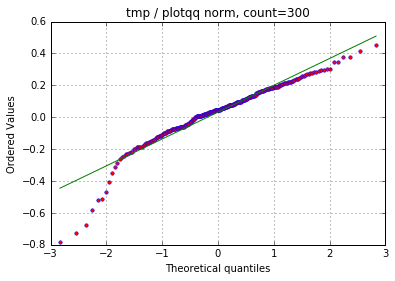

In [13]:
#  Quantile-Quantile plot of geovolatility
fe.plots.plotqq(ss)

Analytically the geometric mean rate should decrease
as volatility and kurtosis increases
(think of the arithmetic mean rate being
penalized by risk factors).

The Quantile-Quantile plot shows that the
geometric mean rate is clearly not distributed normally.
(This is expected since the same goes for the
arithmetic mean rate.)

What is remarkable about the Q-Q plot is that the
geometric mean rates show the greatest deviation
from normal behavior (green line) on the downside.
This captures the frequent observation by traders that
there is more *violence* (extreme absolute percentage changes)
during sell-offs to the bottom that blow-offs to the top.

In [14]:
#  Compute "geovolatility" per our definition.
geovol = fe.std(ss)
geovol

0.17352364223386499

In [15]:
geovol / fe.bs.SPXsigma

1.119969808397435

We are most interested in the **relationship
between geovolatility and volatility**.

Since this is only an informal demonstration, let's just
*hypothesize that geovolatility is larger than volatility*
(say between 10% and 20% more), given U.S. stock market conditions
over the last 51 years, for short-term price paths.

Thus, **there is more *uncertainty* surrounding the geometric mean rate,
relative to the arithmetic mean rate, especially during downturns.**

More formal small-sample studies should adopt
Bradley Efron's recommendations in regards to methodology.
All the necessary tools are available in fecon236.

### Bootstrap to estimate probability

Probabilities are difficult to calculate analytically,
especially for non-symmetrical non-Gaussian processes.
Bootstrapping can help here.

For example, relative to an investment made at current price,
***what is the probability that an asset will reach below
a certain price level during some fixed time duration?***

The gist of the next function is the conditional `prices < level`
embedded in the pandas syntax.

In the general, complex questions regarding probability may be asked
by forming conditionals, which in turn, will have applications,
for example, in pricing exotic derivatives.

In [16]:
fe.bs.smallsample_loss??

Signature: fe.bs.smallsample_loss(N, poparr, yearly=256, repeat=100, level=0.9, inprice=1.0, replace=True)
Source:   
def smallsample_loss(N, poparr, yearly=256, repeat=100, level=0.90,
                     inprice=1.0, replace=True):
    '''Demo small sample statistics: probability of loss: price < level.
       Relative to investment at initial price, inprice.
    '''
    ssarr = np.ones((repeat,))  # small sample array to fill-in.
    for i in range(repeat):
        prices = bsret2prices(N, poparr, inprice=inprice, replace=replace)
        count = prices[prices < level].dropna().shape[0]
        prob = count / float(N)
        ssarr[i] = prob
    #  For user's convenience, we convert array to DataFrame format:
    return tool.todf(ssarr)
File:      /media/yaya/virt18g/virt/dbx/Dropbox/ipy/fecon236/fecon236/boots/bootstrap.py
Type:      function


#### Example: prob(Loss > 10% during 10-year horizon)

The estimated probability will vary according to the
market conditions which are parameterized to produce poparr.

In [17]:
#  Invest at inprice, then
#  assuming market conditions embedded in poparr:
lossprob = fe.bs.smallsample_loss(2560, poparr, yearly=256, repeat=500, level=0.90, inprice=1.0)

#  ... effectively simulates 5,000 years of bootstrapped daily data.

In [18]:
fe.stat(lossprob)

                Y
count  500.000000
mean     0.126914
std      0.225565
min      0.000000
25%      0.000000
50%      0.007227
75%      0.151172
max      0.968359
kurtosis  6.808142


The mean probability of loss is around 13%,
but the median probability is around 1%.
This could lead to complacency with respect to risk,
as the next graph shows that a fifth
of subsamples meet outcomes far worst
than being submerged 10% temporarily.

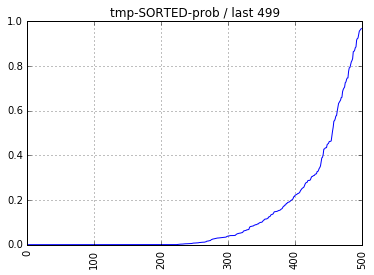

In [19]:
#  toar() is for conversion to numpy array:
probarr = fe.toar(lossprob)
fe.plotn(fe.np.sort(probarr), title="tmp-SORTED-prob")

### SUMMARY

(Please see top of this notebook.)

---

### APPENDIX 1: Hybrid population of empirical and synthetic returns

Thus far the source of our "population" has been truly empirical.
The idea in this appendix is to mix in synthetic data derived
from a theoretical model of the market.

We can express anticipated market conditions by altering the
parametization of the population array, and also by
overlaying the structure of a theoretical model to
produce hybrid results.


#### A look at the synthetic Gaussian Mixture

We covered the mathematics and fitting of GM(2) models
in detail at https://git.io/gmix -- here we focus
on generating synthetic GM(2) returns algorithmically.
The code is located in this module: `fecon236/fecon236/prob/sim.py`

In [20]:
#  This show is generated purely by algorithm.
#  Empirical returns and bootstrapping are NOT involved.

#  Uncomment for the show:
#  fe.sim.gmixshow(N=256, mean=fe.bs.SPXmean, sigma=fe.bs.SPXsigma, yearly=256, repeat=3)

Feeding the historical gross descriptors back into GM(2),
it visually appears as though we have synthetically generated
returns from a ***jump-diffusion process***, sometimes characterized
by "choppy" returns, self-similar to minute transactional data
or returns in liquid markets during periods of extreme uncertainty.

We can express our own pseudo-Bayesian prior
with respect to the empirical distribution
by appending *custom* synthetic returns to empirical returns.

In the next cell, we shall express a complete reversal of the mean,
such that the hybrid population has mean zero.
The number of synthetic returns to be appended shall equal
the number of empirical returns, thus doubling the population size.

In [21]:
#  The mean and sigma arguments are the gross descriptors of the GM(2).
#  But note here that the sign of the mean here is REVERSED.
poparr2 = fe.bs.hybrid2ret(poparr,
                           mean=-fe.bs.SPXmean, sigma=fe.bs.SPXsigma,
                           yearly=256)

In [22]:
#  Population size should double, expect (32084,)
poparr2.shape

(32084,)

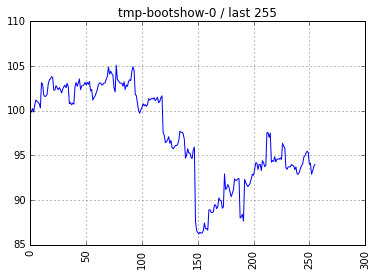

Geometric  mean rate: -8.2519
Arithmetic mean rate: -5.938
sigma: 17.5196
kurtosis (Pearson): 25.1325
GM(2), sigma1: 10.2788
GM(2), sigma2: 61.3187
GM(2), q:  0.0551
GM(2), b:  3.5
yearly: 256
N: 255
---------------------------------------0


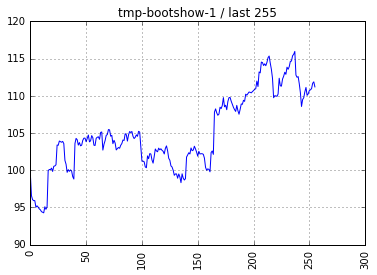

Geometric  mean rate: 10.0225
Arithmetic mean rate: 11.0864
sigma: 14.5729
kurtosis (Pearson): 13.7587
GM(2), sigma1: 12.028
GM(2), sigma2: 51.0053
GM(2), q:  0.0276
GM(2), b:  3.5
yearly: 256
N: 255
---------------------------------------1


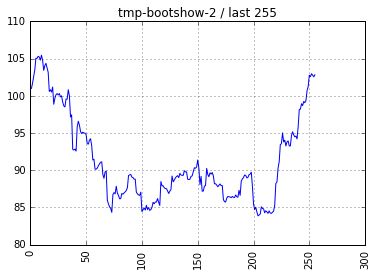

Geometric  mean rate: 0.4107
Arithmetic mean rate: 1.8471
sigma: 16.3552
kurtosis (Pearson): 7.8755
GM(2), sigma1: 15.1278
GM(2), sigma2: 57.2434
GM(2), q:  0.0127
GM(2), b:  3.5
yearly: 256
N: 255
---------------------------------------2


In [23]:
#  ENCOURAGE re-running this cell, like playing with a kaleidoscope:
fe.bs.bootshow(256, poparr2, repeat=3)

#  Visually see the increased "choppiness" due to GM(2) overlay.
#  Local "downtrends" are more likely. 

#### Example: prob(Loss > 10% during 10-year horizon)

Repeat the earlier experiment, but instead ***with the hybrid population***.

In [24]:
#  Invest at inprice, then
#  assuming market conditions embedded in poparr2:
lossprob2 = fe.bs.smallsample_loss(2560, poparr2, yearly=256, repeat=500, level=0.90, inprice=1.0)

#  ... effectively simulates 5,000 years of bootstrapped hybrid daily data.

In [25]:
fe.stat(lossprob2)

                Y
count  500.000000
mean     0.423160
std      0.346069
min      0.000000
25%      0.075000
50%      0.369531
75%      0.767188
max      0.989453
kurtosis  1.498012


The mean probability of loss for the hybrid population is around 42%,
which is far higher than 13% for the empirical population.
This was expected since our synthetic data overlayed a
negative view of the market (but the magnitudes were not
easy to estimate, cf. mean versus median, relative to std).

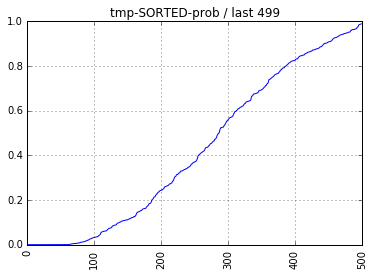

In [26]:
#  toar() is for conversion to numpy array:
probarr2 = fe.toar(lossprob2)
fe.plotn(fe.np.sort(probarr2), title="tmp-SORTED-prob")

---

### Questions or bugs?

- Chat with fellow users at Gitter: https://gitter.im/rsvp/fecon235

- Chat with fellow developers at Gitter: https://gitter.im/MathSci/fecon236


- Report issues regarding our Jupyter notebooks at https://github.com/rsvp/fecon235/issues

- Report issues regarding our Python code at https://github.com/MathSci/fecon236/issues

- Please see https://git.io/econ for orientation and installation details.